In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Helper Functions

In [2]:
def showHeadTail(t_df,n=10,notebook=True):
    if notebook:
        from IPython.display import display
        display(pd.concat([t_df.head(n),t_df.tail(n)]))
    else:
        print(pd.concat([t_df.head(n),t_df.tail(n)]))
        
def getBothValCnts(df,col):
    return df[col].value_counts().to_frame('Count').join(df[col].value_counts(1).to_frame('Percent'),how='left')
        
def countUpper(df,col):
    df[col.upper()+'_UPPER_CNT'] = df[col].apply(lambda row: sum([1 for word in row.split() if word.isupper()]))
    return df

def exploreTokens(vect,arr,mdl,cnt=None):
    t_dtm = getDTM(vect,arr)
    t_df = DTMtoDF(t_dtm,vect)
    if showTokens:
        visualizeTokens(t_df,mdl,cnt)
        
def plotTokens(tokens,t_df):
    plt.scatter(t_df[0], t_df[1])
    for row in t_df.values:
        plt.annotate(s=tokens[int(row[0])],xy=(row[1], row[2]))
    plt.show()
        
def visualizeTokens(t_df,mdl,cnt=None):
    X_T = t_df.T
    tokens = X_T.index.values.tolist()
    z = dr_mdl.fit_transform(X_T)
    z_df = pd.DataFrame(z)
    z_df['sum'] = abs(z_df[0]) + abs(z_df[1])
    z_df = z_df.sort_values('sum',ascending=False)
    z_df = z_df.reset_index().rename(columns={'index':'idx'})
    plotTokens(tokens,z_df.iloc[:cnt])
    return z,tokens

def juxtapose_categories(df,cat_col,val_col):
    options = df[cat_col].unique()
    df_juxtapose = pd.DataFrame()
    for opt in options:
        t_df = df.pivot(index='id',columns=cat_col,values=val_col)[[opt]].dropna().reset_index(drop=True)
        df_juxtapose = pd.concat([df_juxtapose,t_df],axis=1)
    return df_juxtapose

## Load Global Variables

In [3]:
####################
# GLOBAL VARIABLES #
####################
dta_pth = '../data/'
fn = 'news.csv'
f_pth = os.path.join(dta_pth,fn)
y_map = {'FAKE':0,'REAL':1}
X_col = 'title' # can be changed to 'text' to reproduce results for text of article column
y_col = 'label'
random_state = 42

showTokens = True
wordnet_lemmatizer = WordNetLemmatizer()

In [4]:
# Load the data
df = pd.read_csv(f_pth)
# encode y feature as Fake = 0, Real = 1
df['Target'] = df['label'].map(y_map)
print('File "{}": {} rows x {} columns\n'.format(fn,df.shape[0],df.shape[1]))
df.info()

File "news.csv": 6335 rows x 5 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 5 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
Target        6335 non-null int64
dtypes: int64(2), object(3)
memory usage: 247.6+ KB


## Create X matrix of independent variables and Y dataframe to hold targets
- Do this prior to exploring the data to keep original data and explored data separate
- Looking 

In [5]:
# y cols are in final two slots since encoded label as numeric
X = df[df.columns[:-2]]
y = df[df.columns[-2:]]

# Quickly inspect the first and last few rows to get a very high level of the data contents
- The Title and Text fields represent the title of the article, while the text column contains the content for each article.
- The label column indicates whether the article is real or fake, which is also encoded as 1/0 in the Target column.
- The unnamed column is a unique ID for each article in the dataset.  This may be helpful later to keep track of our articles, so rename it ID

In [6]:
# Rename unnamed column to id
cols = df.columns.tolist()
cols[0] = 'id'
df.columns = cols
df.head()

,id,title,text,label,Target
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1


In [7]:
# first 10 entries
df.head(10)

,id,title,text,label,Target
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE,0
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE,0
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL,1
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL,1
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL,1


In [8]:
# last 10 entries
df.tail(10)

,id,title,text,label,Target
6325,8411,Will the Media Reset After the Election or Are...,Written by Peter Van Buren venerable New Yor...,FAKE,0
6326,6143,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,FAKE,0
6327,3262,GOP Senator David Perdue Jokes About Praying f...,The freshman senator from Georgia quoted scrip...,REAL,1
6328,9337,Radio Derb Is On The Air–Leonardo And Brazil’s...,,FAKE,0
6329,8737,Assange claims ‘crazed’ Clinton campaign tried...,Julian Assange has claimed the Hillary Clinton...,FAKE,0
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL,1
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,0
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,0
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL,1
6334,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,REAL,1


# Explore the Independent and Dependent Variables

## Inspect the dependent variable, 'label' first
- The dependent variable 'label' is evenly distributed
- There are only two categories in this dataset

In [9]:
# use helper function that returns df of joined pd.value_count options 0 (ie, counts) and 1 (ie, percents)
getBothValCnts(df,'label')

,Count,Percent
REAL,3171,0.500552
FAKE,3164,0.499448


## Also, looking at the ID column the Real and Fake articles are sorted by ID
- Lower values are REAL articles and higher values are FAKE
- We can see this by doing a quick scatter plot

In [10]:
df.sort_values([df.columns[0]])

,id,title,text,label,Target
5603,2,Study: women had to drive 4 times farther afte...,Ever since Texas laws closed about half of the...,REAL,1
565,3,"Trump, Clinton clash in dueling DC speeches","Donald Trump and Hillary Clinton, now at the s...",REAL,1
2099,5,"As Reproductive Rights Hang In The Balance, De...",WASHINGTON -- Forty-three years after the Supr...,REAL,1
2197,6,"Despite Constant Debate, Americans' Abortion O...",It's been a big week for abortion news.\n\nCar...,REAL,1
5974,7,Obama Argues Against Goverment Shutdown Over P...,President Barack Obama said Saturday night tha...,REAL,1
...,...,...,...,...,...
1213,10549,French Political Leader: “France is about to E...,"Posted on October 31, 2016 by Theodore Shoebat...",FAKE,0
4863,10551,Man with unfashionable front door feared by ne...,Man with unfashionable front door feared by ne...,FAKE,0
5397,10553,Obamacare Architect on Rising Premiums: It’s N...,"Washington Free Beacon October 26, 2016 \nDr. ...",FAKE,0
208,10555,Clinton Vs. Trump: Latest Electoral Prediction...,(Before It's News)\nIt is fun to look at polls...,FAKE,0


## Scatter of y variable by ID

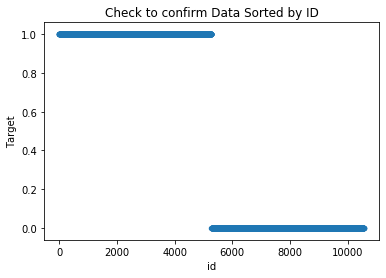

In [11]:
df.plot(kind='scatter',x='id',y='Target')
plt.title('Check to confirm Data Sorted by ID')
plt.show()

# Explore the dependent data, 'title' and 'text'

## 'Nulls'
### While the dataframe does not have any Null values as seen at the import stage, check at a high level and see if any the contents of the Text and Title column carry emptry strings.
- The Title field only appears to contain one row with a 'missing' title as shown by the single row with a string length of 1.  The next shortest is 5.  Assume titles of length <=1 are 'null'

In [12]:
df['title'].apply(lambda x: len(x)).value_counts().sort_index()

1      1
5      1
8      2
9      4
10     2
      ..
221    1
229    2
231    1
269    1
289    1
Name: title, Length: 168, dtype: int64

In [13]:
df.loc[df['title'].apply(lambda x: len(x) <= 5),'title']

2417    White
3456        :
Name: title, dtype: object

### There are a few dozen rows in the Text column which  appear to contain only empty string values.  
- 36 title have a length of just 1, 
- The next shortest length, as 12 characters long.

In [14]:
# It appears that 36 of the artilces do not have any text as shown by this value count on string length
df['text'].apply(lambda x: len(x)).value_counts().sort_index()

1         36
12         1
13         1
17         1
34         1
          ..
56795      1
68208      1
92561      1
99355      1
115372     1
Name: text, Length: 4562, dtype: int64

### Inspecting these that rows only have empty strings for the text contents, we see that they are all FAKE articles.  There are a few options for handling this missing data.  
1. Leave the missing information as is
2. Impute the TITLE values for the text values.
3. Remove these rows from the data set.

At this point, it is too early to say which is the 'best' option.  The best answer depends on a few things: 
    <li> **a)** which scenario will most represent the real-world, out of sample articles the model will be classifying (ie, do all articles missing a text component get set to FAKE by default prior to modeling? </li>
    <li> **b)** which column features we end up using to build our final model </li>

In [15]:
df.loc[df['text'].apply(lambda x: len(x) == 1), :]

,id,title,text,label,Target
106,5530,The Arcturian Group by Marilyn Raffaele Octobe...,,FAKE,0
710,8332,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,,FAKE,0
806,9314,Southern Poverty Law Center Targets Anti-Jihad...,,FAKE,0
919,10304,Refugee Resettlement Watch: Swept Away In Nort...,,FAKE,0
940,9474,Michael Bloomberg Names Technological Unemploy...,,FAKE,0
1664,5802,Alert News : Putins Army Is Coming For World W...,,FAKE,0
1736,9564,An LDS Reader Takes A Look At Trump Accuser Je...,,FAKE,0
1851,5752,America’s Senator Jeff Sessions Warns of Worse...,,FAKE,0
1883,8816,Paris Migrant Campers Increase after Calais Is...,,FAKE,0
1941,7525,Putins Army is coming for World war 3 against ...,,FAKE,0


## For this analysis, assume option two and impute the title values for missing text value 
- This won't assume these rows will be filtered out in a real world scenario 
- It will still capture relevant information for each of these articles missing text


In [16]:
# set blank text entries to that articles title text 
df.loc[df['text'].apply(lambda x: len(x) == 1), 'text'] = df.loc[df['text'].apply(lambda x: len(x) == 1), 'title']

## Visually inspect the tokens  
- Start with the Title column first
- These are shorter than full text of articles so this should be a good starting point before diving into full text

In [17]:
# create a tokenizer that cleans converts raw text to lemmas of tokens using NLTK
# NB: add regex to remove non-alphanermic tokens and tokens that are all digits
#def getLemms(s):
#    return [wordnet_lemmatizer.lemmatize(t.strip()) for t in nltk.tokenize.word_tokenize(s) if t not in r'''!'?s’-:,@;#$.%"^""&*.'.''.''']

In [18]:
# initialize a vectorize using our lemma tokenizer and removing english stop words
#vect = CountVectorizer(tokenizer=getLemms,strip_accents='unicode', stop_words = 'english')
vect = CountVectorizer(strip_accents='unicode', stop_words = 'english')

In [19]:
# convert the titles to a document term matrix
dtm = vect.fit_transform(df['title'])

In [20]:
### transform titles from columns of single strings to a sparse DTM: document term matrix
dtm

<6335x9820 sparse matrix of type '<class 'numpy.int64'>'
	with 44923 stored elements in Compressed Sparse Row format>

In [21]:
### convert DTM sparse matrix to a sparse DataFrame with TOKENS AS COLUMNS
df_dtm = pd.DataFrame(dtm.toarray(),columns=vect.get_feature_names())
df_dtm.sample(10,random_state=random_state)

,00,000,00pm,01,04,05,06,08,10,100,...,ارزی,القادمون,امریکا,ایران,جنگ,سال,علیه,مطالعاتی,مورد,کدامایی
1357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
812,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## There are ~9800 different tokens, which are the most important?  Will we need all of them for building a model?
- Use Singular Value Decomposition to find out which ones contain are the most and least similar
- This information indicates how far apart the tokens are from each other and the magnitude of that difference
- Later we'll look at removing tokens both by LSA to obtain more components (SVD with a range of components) and parameter tuning on Count and Tfidf Vectorizers.

In [22]:
# The most frequent tokens are shown below: 
# not suprisingly Trump, Clinton, Hillary and Obama are the most common 
# as they all were President or their respective Party Nominees for President
df_dtm.sum(axis=0).sort_values(ascending=False).to_frame('Token_Counts').head(10)

,Token_Counts
trump,1115
clinton,723
hillary,591
obama,378
new,280
donald,269
gop,256
election,243
2016,214
video,201


### Transpose the Document Term Matrix to a Term-Document Matrix with the TOKENS AS ROWS for input into SVD
- The CountVectorizer returned each document encoded as a vector across tokens
- Transpoing this data will provide each token encoded as a vector across documents

In [23]:
# The Transposed dataframe now shows the tokens in the index and has 1 column for each of the 6335 documents in data
new_X = df_dtm.T 
new_X.sample(10,random_state=random_state)

,0,1,2,3,4,5,6,7,8,9,...,6325,6326,6327,6328,6329,6330,6331,6332,6333,6334
provocative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gambling,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
arabian,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
warplane,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
advertisers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
contamination,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
paperwork,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
monopoly,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lie,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chose,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Transform these 6335 document term-counts into 2 components using SVD
- Create a list of the unique tokens in order to graph them with corresponding transformed values
- dr_mdl is the diminensionality reduction model used
- z is the numpy matrix storing the resulting values of svd

In [24]:
# list of unique individual tokens
tokens = new_X.index.values.tolist()
# instantiate default SVD object, which defaults to 2 components
dr_mdl = TruncatedSVD(random_state=random_state)
# fit_transform the token term-document matrix using SVD object
z = dr_mdl.fit_transform(new_X)
# inspect transformed data, which is stored as a numpy matrix - new components are positive and negative
z[:10,:]

array([[ 2.24643189e-02, -1.56780280e-02],
       [ 1.96290195e-01,  3.59830136e-01],
       [ 4.69424422e-03,  5.20424415e-03],
       [ 3.01194521e-02, -1.94532739e-02],
       [ 1.00305770e-03,  1.42551311e-03],
       [ 9.36858597e-05, -1.46129804e-05],
       [ 2.12326277e-03,  2.40865423e-03],
       [ 1.67637254e-03,  1.94708295e-03],
       [ 1.65770770e-01,  8.16220375e-04],
       [ 5.81447706e-02,  5.14161206e-02]])

In [25]:
# convert the numpy matrix z into a dataframe and inspect the first few rows
z_df = pd.DataFrame(z)
z_df.head()

,0,1
0,0.022464,-0.015678
1,0.196290,0.359830
2,0.004694,0.005204
3,0.030119,-0.019453
4,0.001003,0.001426


## Sum the absolute value of both component columns in order to sort the data 
- This will allow us to zoom in on a subset of top N tokens that are have the largest magnitude of transformed values
- Using the original transformed sign-indeterminant values to graph the tokens will allow us to capture the sign (direction) of the similarity.

In [26]:
z_df['sum'] = abs(z_df[0]) + abs(z_df[1])
z_df = z_df.sort_values('sum',ascending=False)
z_df = z_df.reset_index().rename(columns={'index':'idx'})

## Plot the tokens interactively
- Adjust N to see only the number of desired tokens
- Plotting these 100 shows that the most similar word combinations are 1) clinton/hillary/fbi and 2) trump/donald/gop  Additionally, these word combinations are most disimilar to each other.
- Change to %matplotlib qt to view outside notebook)

<IPython.core.display.Javascript object>


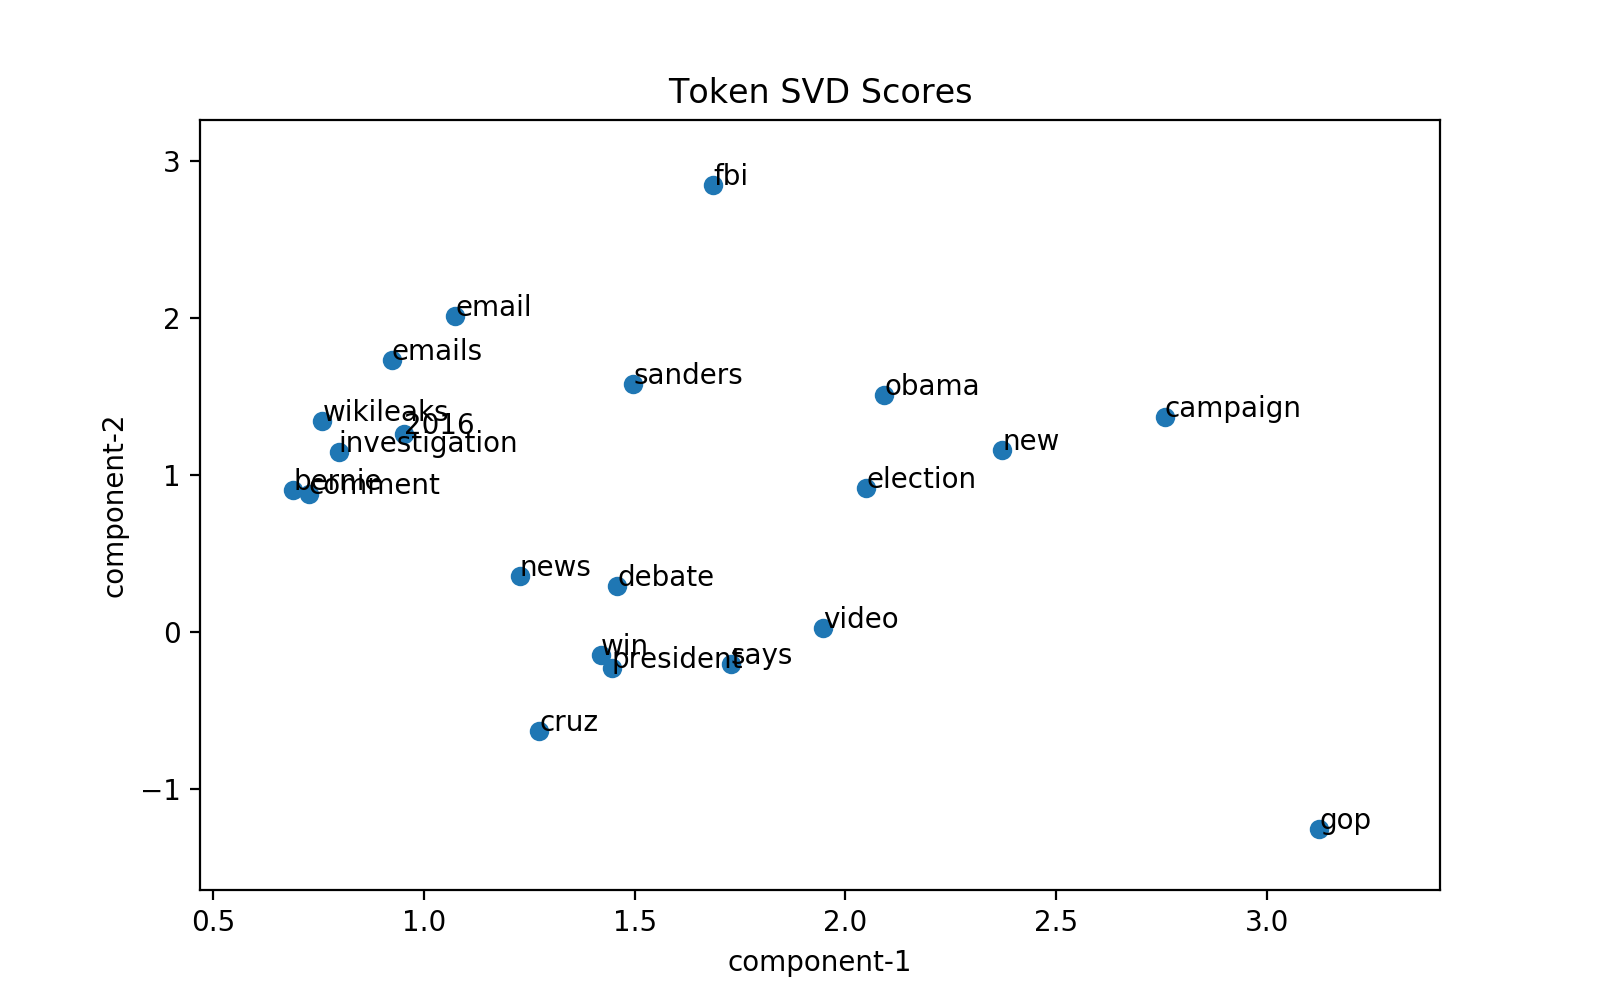

In [31]:
%matplotlib notebook
N = 25 # number of top tokens to capture

# Grab only the top N
t_df = z_df.iloc[:N].copy(deep=True)
plt.figure(figsize=(8,5))
plt.scatter(t_df[0], t_df[1])
for row in t_df.values:
    plt.annotate(s=tokens[int(row[0])],xy=(row[1], row[2]))
plt.title('Token SVD Scores')
plt.xlabel('component-1')
plt.ylabel('component-2')
plt.show()
